## Challenge Description

Company XYZ is an e-commerce site that sells hand-made clothes. 

We have to build a model that predicts whether a user has a high probability of using the site to perform some illegal activity or not. 

We only have information about the user first transaction on the site and based on that you have to make your classification (“fraud/no fraud”).

#### These are the tasks you are asked to do:


* For each user, determine her country based on the numeric IP address.


* Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.


* If boss is a bit worried about using a model she doesn’t understand for something as important as fraud detection. How would we explain her how the model is making the predictions? Not from a mathematical perspective (she couldn’t care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?


* Let’s say we now have this model, which can be used, live to predict in real time if an activity is fraudulent or not. From a product perspective, how would we use it? That is, what kind of different user experiences would you builds based on the model output?


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings 
warnings.simplefilter('ignore')

In [2]:
data = pd.read_csv('Fraud_Data.csv')
country = pd.read_csv('IpAddress_to_Country.csv')

In [3]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [4]:
country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [5]:
data.shape

(151112, 11)

In [6]:
country.shape

(138846, 3)

---

<font size=5>Question 1:
    
    For each user, determine her country based on the numeric IP address.

In [7]:
cty = len(data) * [0]
for i in range(len(data)):
    temp = country[(country['lower_bound_ip_address'] <= data['ip_address'][i]) & 
                  (country['upper_bound_ip_address'] >= data['ip_address'][i])]['country']
    
    if (len(temp) == 1):
        cty[i] = temp.values[0]
        
data['country'] = cty

In [166]:
data.loc[data['country']==0,'country'] = np.nan

In [167]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [168]:
data.groupby('country').size().nlargest(10)

country
United States        58049
China                12038
Japan                 7306
United Kingdom        4490
Korea Republic of     4162
Germany               3646
France                3161
Canada                2975
Brazil                2961
Italy                 1944
dtype: int64

---

<font size=5> Question 2:
    
    Build a model to predict whether an activity is fraudulent or not.

<font size=4>A few obious variables that can be created here could be:

    1. Time difference between sign-up time and purchase time.
    
    2. If the device id is unique or certain users are sharing the same device (many different user ids using the same device could be an indicator of fake accounts)
    
    3. Same for the ip address. Many different users having the same ip address could be an indicator of fake accounts
    
    4. Usual week of the year and day of the week from time variables.

In [170]:
# find missing values
missing = data['country'].isna().sum()
print('country has missing values:', missing,'\nthe missing percentage is:',str(round(missing/len(data)*100,2))+'%')

country has missing values: 21966 
the missing percentage is: 14.54%


### Feature Engineering

In [171]:
# Time difference between sign-up time and purchase time
data['signup_time'] = pd.to_datetime(data['signup_time'])
data['purchase_time'] = pd.to_datetime(data['purchase_time'])

data['time_diff'] = data['purchase_time'] - data['signup_time']

# time difference in seconds
data['time_diff'] = data['time_diff'].dt.seconds

In [172]:
# check the device id is unique or certain users are sharing the same device
data['device_id_count'] = data.groupby('device_id')['device_id'].transform('count')
data['ip_address_count'] = data.groupby('ip_address')['ip_address'].transform('count')

In [179]:
# keep the top 50 countries, and set other countries as 'others'
other_countries = data.groupby('country').size().sort_values(ascending=False)[50:].index
data.loc[data['country'].isin(other_countries),'country'] = 'others'

# fill country variable missing values as 'others'
data.loc[data['country'].isna(),'country'] = 'others'

### Visualization

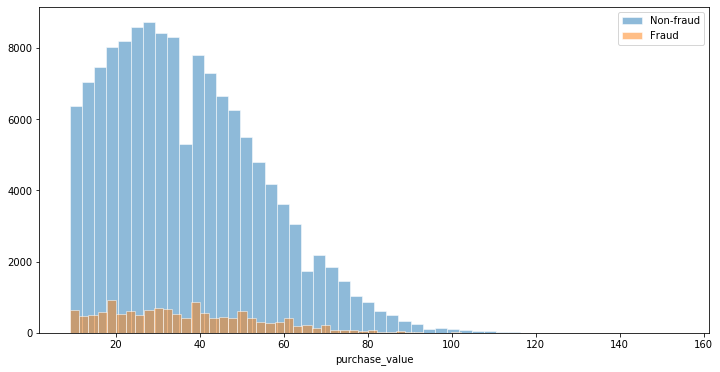

In [180]:
# distribution of purchase value 
plt.subplots(figsize=(12,6))
sns.distplot(data[data['class']==0]['purchase_value'],kde=False,
             hist_kws={'edgecolor':'white','alpha':0.5})
sns.distplot(data[data['class']==1]['purchase_value'], kde=False,
             hist_kws={'edgecolor':'white','alpha':0.5})
plt.legend(['Non-fraud','Fraud'])
plt.show()

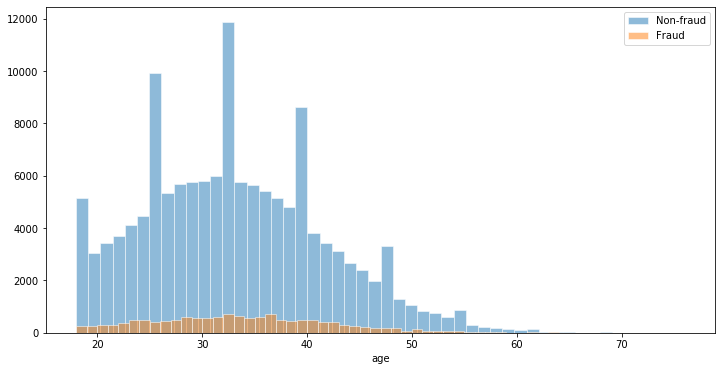

In [181]:
# distribution of age
plt.subplots(figsize=(12,6))
sns.distplot(data[data['class']==0]['age'],kde=False,
             hist_kws={'edgecolor':'white','alpha':0.5})
sns.distplot(data[data['class']==1]['age'], kde=False,
             hist_kws={'edgecolor':'white','alpha':0.5})
plt.legend(['Non-fraud','Fraud'])
plt.show()

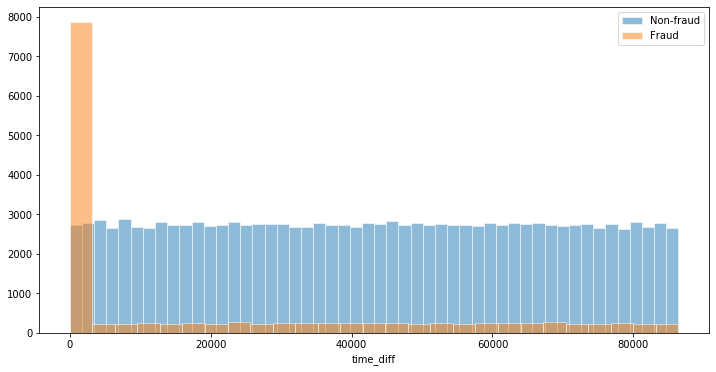

In [182]:
# distribution of time_diff
plt.subplots(figsize=(12,6))
sns.distplot(data[data['class']==0]['time_diff'],kde=False,
             hist_kws={'edgecolor':'white','alpha':0.5})
sns.distplot(data[data['class']==1]['time_diff'], kde=False,
             hist_kws={'edgecolor':'white','alpha':0.5})
plt.legend(['Non-fraud','Fraud'])
plt.show()

<font size=4>
    
    From the above charts, we can see that the majority of the fraud activities have a short time to make a purchase since signing up.

In [183]:
data['class'].value_counts()

0    136961
1     14151
Name: class, dtype: int64

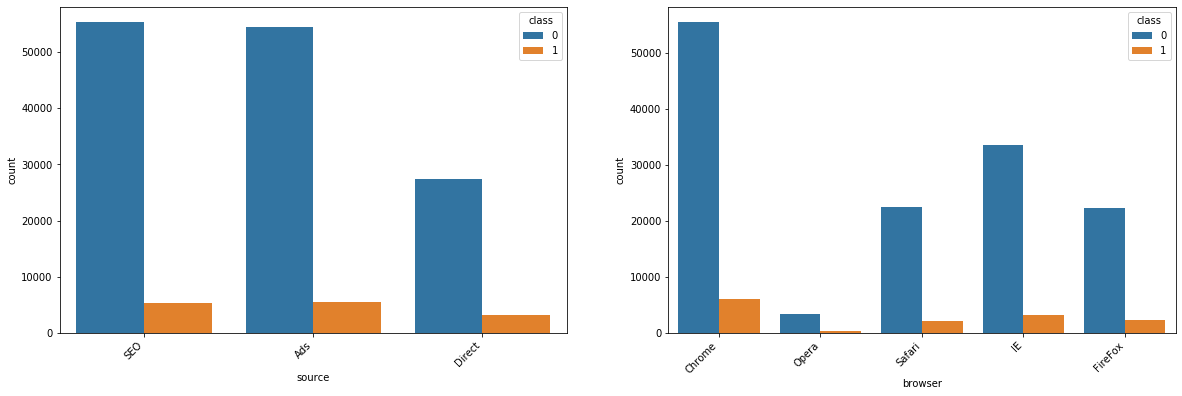

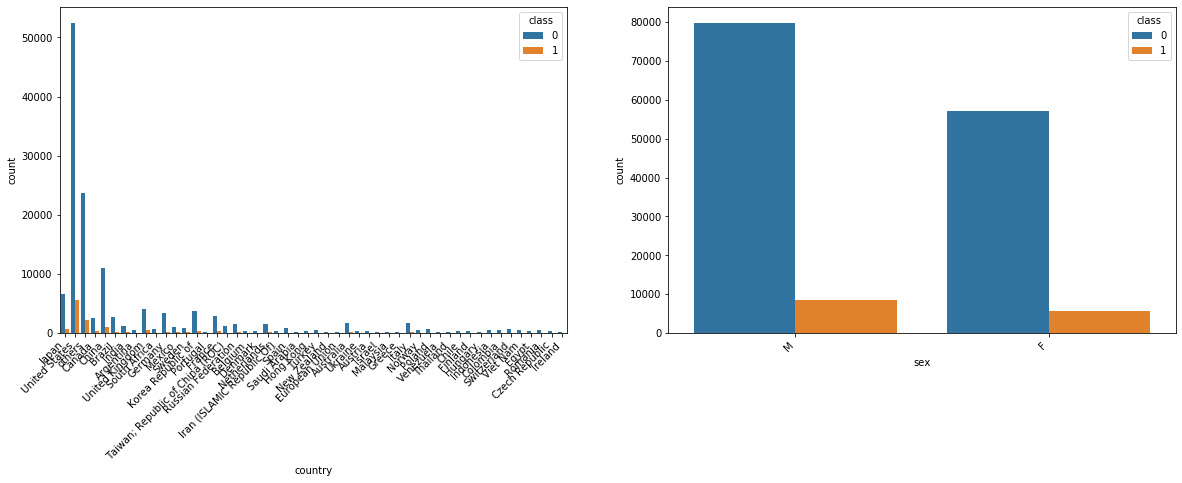

In [184]:
cat_col = ['source','browser','country','sex']
ncol = 2
nrow = 2
for i in range(nrow):
    fig, ax = plt.subplots(1,ncol, figsize=(20,6))
    for j in range(ncol):
        chart = sns.countplot(x = data[cat_col[i*ncol+j]], hue = data['class'], ax=ax[j])
        chart.set_xticklabels(chart.get_xticklabels(),rotation=45,horizontalalignment='right')

### Feature selection

In [186]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_id_count,ip_address_count
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,others,60085,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1,1


In [188]:
features = data.drop(['user_id','signup_time','purchase_time','device_id','ip_address'], axis=1)

### dummy variables

In [190]:
data_dummy = pd.get_dummies(features)

## Build model

#### random forest

In [194]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [192]:
X = data_dummy.drop('class', axis= 1)
y = data_dummy['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [205]:
rfc = RandomForestClassifier(n_estimators = 100, max_features= 3, oob_score=True, class_weight={0:1,1:10})
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 10},
                       criterion='gini', max_depth=None, max_features=3,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=True,
                       random_state=None, verbose=0, warm_start=False)

In [206]:
# oob accuracy and confusion_matrix for train dataset
print('oob accuracy: ',rfc.oob_score_,
      '\noob confusion matrix:\n',
     pd.DataFrame(confusion_matrix(y_train, rfc.oob_decision_function_[:,1].round(), labels=[0,1])))

oob accuracy:  0.9549508617709517 
oob confusion matrix:
        0     1
0  91496   280
1   4281  5188


In [209]:
# oob accuracy and confusion_matrix for test dataset
print('oob accuracy: ',rfc.score(X_test, y_test),
      '\noob confusion matrix:\n',
     pd.DataFrame(confusion_matrix(y_test, rfc.predict(X_test), labels=[0,1])))

oob accuracy:  0.9549401407744601 
oob confusion matrix:
        0     1
0  45070   115
1   2132  2550


<font size=4>
    
    The confusion matrix looks good. We are not overfitting given that OOB and test results are very similar. Class 0 error is almost zero, and we are doing surprisignly well also with regards to class 1 error, which is pretty rare.
    
    However, since the challenge asks about false positives and false negatives, this usually implies building the ROC and look for possible cut-off points. And in general, especially when dealing with fraud, you should always do the cut-off analysis. There is no reason why the default 0.5 value has to be the best one.
    
    Is really 0.5 the best possible cut-off? It really depends on what we are optimizing for (accuracy? true positive? true negative? etc.)

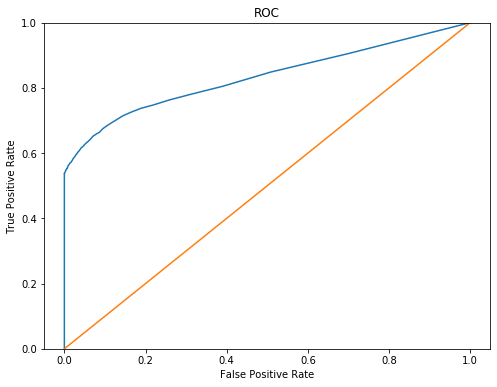

In [211]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])

# plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
plt.ylim([0,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Ratte')
plt.title('ROC')
plt.show()

<font size=4>
    
    Based on the ROC, if we care about minimizing false positive, we would choose a cut-off that would give us true positive rate near 0.6 and false positive rate basically zero.
    
    However, if we care about maximizing true positive rate, we will have to significantly decrease the cut-off. This way we will classify more events as “1”: some will be true ones (so true positive goes up) and many, unfortunately, will be false ones (so false positive will also go up).
    
    If we want to be a bit more accurate, we can use the approach of maximizing true positive rate - false positive rate, this is the same as maximizing (1-class1_error - class0_error) as we saw in the unbalanced data section.

In [212]:
# We will focus on class errors, defined as class0_error = fpr and class1_error = 1 - tpr
error_cutoff = pd.DataFrame({'cutoff':pd.Series(thresholds),
                             'class0_error':pd.Series(fpr),
                             'class1_error': 1 - pd.Series(tpr)
                            })
error_cutoff['optimal_value'] = 1 - error_cutoff['class1_error'] - error_cutoff['class0_error']
print(error_cutoff.sort_values('optimal_value', ascending=False).head(1))

    cutoff  class0_error  class1_error  optimal_value
65    0.16      0.070466      0.348355       0.581179


<font size=4>
    
    The best value is in the area near ~65% true positive rate (specifically 1-0.34 = 0.66) and very low false positive rate (~7%). You can find the corresponding point on the ROC curve.


    Regarding insights, it is the same as in the previous projects. So we won’t do it. At this point, we know the random forest is predicting well, so it simply boils down to building the partial dependence plots and explaining them.

### feature importance

In [225]:
features = X_train.columns
pd.Series(rfc.feature_importances_, index=features).sort_values(ascending=False).head()

time_diff           0.301146
device_id_count     0.221988
purchase_value      0.143096
age                 0.126148
ip_address_count    0.103484
dtype: float64

---

<font size=5> Question 4:
    
    Let’s say we now have this model, which can be used, live to predict in real time if an activity is fraudulent or not. From a product perspective, how would we use it? That is, what kind of different user experiences would you builds based on the model output?

<font size=4>
    
    You now have a model that assigns to each user a probability of committing a fraud. And, despite our model doing pretty well, no model is perfect. So you will have some misclassifications. It is crucial now to think about building a product that minimizes the impact (aka cost) of those misclassifications. A very commonly used approach is to think about creating different experiences based on the model score. For instance:

<font size=4>
    
    1. If predicted fraud probability < X, the user has the normal experience (the high majority of users should fall here)
    
    2. If X <= predicted fraud probability < Z (so the user is at risk, but not too much), you can create an additional verification step, like phone number verifications via a code sent by SMS or asking to log in via social network accounts
    
    3. If predicted fraud probability >= Z (so here is really likely the user is trying to commit a fraud), you can tell the user his activity has been put on hold, send this user info to someone who reviews it manually, and finally either block the user or decide it is not a fraud so the session is resumed